#### The main objective of this Notebook is to build a simple credit model for MarketFinance based on track-record
- The given dataset contains publicly available Loan book

### Notebook BreakDown
1. Data Loading
2. Feature Creation<br>
    2.1 The expected duration<br>
    2.2 The number of previously settled trades for the seller <br>
3. Modelling <br>
    3.1 Logistic Regression<br>
    3.2 Model Evaluation<br>
4. Previously settled trades and In Arrears<br>
    4.1 Scatter plot<br>
5. Model performance improvement<br>
    5.1 Data Distributions<br>
    5.2 Random forest and Recursive feature elimination <br>

In [1]:
##Importing necessary Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import io
import os

import warnings
warnings.simplefilter('ignore')

### 1. Data Loading

In [2]:
#Data Loading
df=pd.read_excel('MarketFinance_Public_Loan_Book.xlsx')
df.head(3)

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss
0,60896,44830,Standard,2018-10-11,2019-01-07 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,2617.50,75.0,1.00,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN
1,61210,34501,MultiDebtor,2018-10-11,2019-01-25 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,5679.67,70.0,0.95,Advance,5679.67,8113.8200,5679.6700,5679.6700,12.014922,NaN
2,61343,15942,Standard,2018-10-11,2018-11-26 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,5100.00,85.0,0.70,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN


In [3]:
#working with the Trade Type “Standard”.
df_std=df[df['Trade Type']=='Standard']
print(df_std.shape)
df_std.reset_index(drop=True,inplace=True)
df_std.head(3)

(27766, 23)


,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss
0,60896,44830,Standard,2018-10-11,2019-01-07 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,2617.50,75.0,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN
1,61343,15942,Standard,2018-10-11,2018-11-26 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,5100.00,85.0,0.7,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN
2,61346,25937,Standard,2018-10-11,2018-12-14 00:00:00 +0000,NaT,No,NaT,NaT,Awaiting Repayment,...,2819.84,65.0,1.2,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN


### 2. Feature Creation

#### 2.1 The expected duration

In [4]:
df_std[['Advance Date','Expected Payment Date']].head(3)

,Advance Date,Expected Payment Date
0,2018-10-11,2019-01-07 00:00:00 +0000
1,2018-10-11,2018-11-26 00:00:00 +0000
2,2018-10-11,2018-12-14 00:00:00 +0000


In [5]:
#Checking datatypes
df_std[['Advance Date','Expected Payment Date']].dtypes

Advance Date             datetime64[ns]
Expected Payment Date            object
dtype: object

In [6]:
#converting to datetime64 datatype
df_std['Expected Payment Date']=pd.to_datetime(df_std['Expected Payment Date']).dt.tz_convert(None)
df_std[['Advance Date','Expected Payment Date']].dtypes

Advance Date             datetime64[ns]
Expected Payment Date    datetime64[ns]
dtype: object

In [7]:
df_std[['Advance Date','Expected Payment Date']].head(3)

,Advance Date,Expected Payment Date
0,2018-10-11,2019-01-07
1,2018-10-11,2018-11-26
2,2018-10-11,2018-12-14


In [8]:
#Checking missing values
df_std[['Advance Date','Expected Payment Date']].isnull().sum()

Advance Date             0
Expected Payment Date    0
dtype: int64

In [9]:
# Creating feature The expected duration: the number of days between advance date and expected payment date
df_std['Expected Duration']=df_std['Expected Payment Date']-df_std['Advance Date']
df_std.head()

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Advance %,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,Expected Duration
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,No,NaT,NaT,Awaiting Repayment,...,75.0,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88 days
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,No,NaT,NaT,Awaiting Repayment,...,85.0,0.7,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN,46 days
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,No,NaT,NaT,Awaiting Repayment,...,65.0,1.2,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN,64 days
3,61361,2098,Standard,2018-10-11,2018-12-21,NaT,No,NaT,NaT,Awaiting Repayment,...,80.0,1.2,Advance,2323.20,2904.0000,2323.2000,2323.2000,15.389462,NaN,71 days
4,61362,14523,Standard,2018-10-11,2018-12-19,NaT,No,NaT,NaT,Awaiting Repayment,...,90.0,0.8,Advance,40142.80,44603.1100,40142.8000,40142.8000,10.033869,NaN,69 days


In [10]:
#Checking shape
df_std.shape

(27766, 24)

#### 2.2 The number of previously settled trades for the seller

In [11]:
def make_count_diff(trade_id, seller_id):
    #get all the trades for a seller
    dummy = df_std[df_std['Seller ID']==seller_id]
    
    #get the extact trade row we are interested in
    current_advance_date = dummy[dummy['Trade ID']==trade_id]['Advance Date'].values[0]
    #print(current_advance_date)
    
    #writing condition that satisties the given criteria
    inter_df = dummy[(dummy['Payment State']== 'Paid') & (current_advance_date > dummy['Settlement Date'])]
    return(inter_df.shape[0])

In [12]:
# Counting Previously settled trades for seller
df_std['Numb_prev_setteled_trades'] = df_std.apply(lambda x: make_count_diff(x['Trade ID'], x['Seller ID']), axis=1)

In [13]:
#Check seller id 44830
df_std[df_std['Seller ID']==44830]

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,Expected Duration,Numb_prev_setteled_trades
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,No,NaT,NaT,Awaiting Repayment,...,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88 days,5
14,60895,44830,Standard,2018-10-11,2019-01-03,NaT,No,NaT,NaT,Awaiting Repayment,...,1.0,Advance,2028.00,1916.0876,1532.8701,1532.8701,12.682503,NaN,84 days,5
135,61008,44830,Standard,2018-10-04,2018-11-24,NaT,No,NaT,NaT,Awaiting Repayment,...,1.4,Advance,680.00,654.6078,523.6863,523.6863,18.155913,NaN,51 days,4
476,60299,44830,Standard,2018-09-19,2018-11-12,NaT,No,NaT,NaT,Awaiting Repayment,...,1.4,Advance,920.00,875.3878,700.3102,700.3102,18.155913,NaN,54 days,3
490,60179,44830,Standard,2018-09-19,2018-11-12,NaT,No,NaT,NaT,Awaiting Repayment,...,1.2,Advance,660.60,1101.0000,660.6000,660.6000,15.389462,NaN,54 days,3
508,59963,44830,Standard,2018-09-18,2018-11-06,NaT,No,NaT,NaT,Awaiting Repayment,...,1.0,Advance,8400.00,7985.6373,6388.5098,6388.5098,12.682503,NaN,49 days,3
557,60079,44830,Standard,2018-09-14,2018-11-09,NaT,No,NaT,NaT,Awaiting Repayment,...,1.4,Advance,5231.51,4991.3968,3993.1159,3993.1159,18.155913,NaN,56 days,3
645,59634,44830,Standard,2018-09-12,2018-10-30,NaT,No,NaT,NaT,Awaiting Repayment,...,1.0,Advance,3704.40,3558.1105,2846.4884,2846.4884,12.682503,NaN,48 days,3
647,59670,44830,Standard,2018-09-11,2018-11-02,NaT,No,NaT,NaT,Awaiting Repayment,...,1.4,Advance,1680.00,1615.9149,1292.7319,1292.7319,18.155913,NaN,52 days,3
655,59902,44830,Standard,2018-09-11,2018-11-05,NaT,No,NaT,NaT,Partially Paid,...,1.4,Advance,184.00,2023.7409,1618.9929,141.5849,18.155913,NaN,55 days,3


In [14]:
#Shape of data
df_std.shape

(27766, 25)

### 3. Modelling
Fit a logistic regression to predict In Arrears by using the two features that you
created in the previous step. Interpret your findings and explain how you have
evaluated the model performance.

In [15]:
#Data for modelling
df_modelling=df_std[['Expected Duration','Numb_prev_setteled_trades','In Arrears']]
print(df_modelling.shape)
print(df_modelling.isnull().sum())
df_modelling.head(5)

(27766, 3)
Expected Duration            0
Numb_prev_setteled_trades    0
In Arrears                   0
dtype: int64


,Expected Duration,Numb_prev_setteled_trades,In Arrears
0,88 days,5,No
1,46 days,53,No
2,64 days,4,No
3,71 days,34,No
4,69 days,108,No


No     27241
Yes      525
Name: In Arrears, dtype: int64


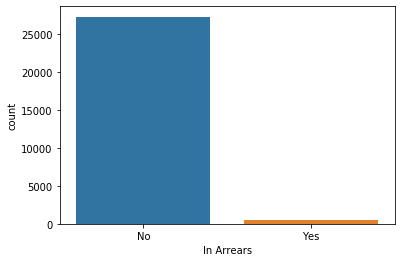

In [16]:
# target variable distribution
print(df_modelling['In Arrears'].value_counts())
sns.countplot(df_modelling['In Arrears'])

In [17]:
df_modelling.describe()

,Expected Duration,Numb_prev_setteled_trades
count,27766,27766.000000
mean,45 days 03:50:37.816033,36.342829
std,22 days 08:35:28.695795,50.094375
min,-285 days +00:00:00,0.000000
25%,30 days 00:00:00,3.000000
50%,42 days 00:00:00,16.000000
75%,57 days 00:00:00,49.000000
max,404 days 00:00:00,356.000000


In [18]:
#Checking datatypes
df_modelling.dtypes

Expected Duration            timedelta64[ns]
Numb_prev_setteled_trades              int64
In Arrears                            object
dtype: object

In [19]:
# datattypes
df_modelling['Expected Duration']=pd.to_timedelta(df_modelling['Expected Duration']).dt.days
df_modelling.dtypes

Expected Duration             int64
Numb_prev_setteled_trades     int64
In Arrears                   object
dtype: object

In [20]:
#df_modelling_test=df_modelling[df_modelling['Expected Duration']>=0]
#df_modelling_test = df_modelling_test.reset_index(drop=True)
#df_modelling_test.head(5)

In [21]:
#X[X['Numb_prev_setteled_trades']>0]

In [22]:
#Dependent and Independent variables
X=df_modelling.drop(columns=['In Arrears'])
y=df_modelling['In Arrears']


#Train and Test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape,y_train.shape,X_test.shape

((20824, 2), (20824,), (6942, 2))

In [23]:
y_test.value_counts()

No     6800
Yes     142
Name: In Arrears, dtype: int64

#### 3.1 Modelling using Logistic Regression

In [25]:
#Modelling
from sklearn.linear_model import LogisticRegression

model_Log=LogisticRegression()
model_Log.fit(X_train,y_train)
y_pred=model_Log.predict(X_test)

from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred))

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print(f1_score(y_test, y_pred, average="macro"))
print(precision_score(y_test, y_pred, average="macro"))
print(recall_score(y_test, y_pred, average="macro"))    
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.9795447997695189
0.5017770499757399
0.7398414985590778
0.5034475973487987
              precision    recall  f1-score   support

          No       0.98      1.00      0.99      6800
         Yes       0.50      0.01      0.01       142

    accuracy                           0.98      6942
   macro avg       0.74      0.50      0.50      6942
weighted avg       0.97      0.98      0.97      6942

[[6799    1]
 [ 141    1]]


#### 3.2 Results interpretation

As the dataset has a severe problem of data imbalances,I have choosed Precision,Recall and Fscore as evaluation techniques

The precision of the model Logistic Regression can be inferred as of all the points
where model predicted as yes, 50 percent are actually Yes. 

Similarly recall of model Logistic Regression can be inferred as of all the points that originally belong to class Yes, 1 percent were classified as class Yes

In [26]:
#df_modelling.to_excel("df_modelling.xlsx")

### 4 
Have a look at the relationship between previously settled trades and In Arrears. Can you visualise this relationship? How would you alter your model based on this? What is the impact on performance?

In [27]:
df_modelling.head(3)

,Expected Duration,Numb_prev_setteled_trades,In Arrears
0,88,5,No
1,46,53,No
2,64,4,No


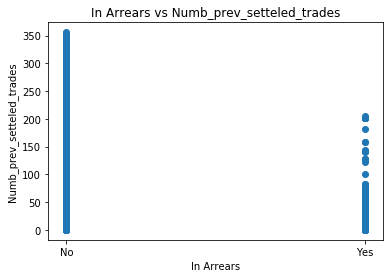

In [28]:
#relationship between previously settled trades and In Arrears
plt.scatter(df_modelling['In Arrears'], df_modelling['Numb_prev_setteled_trades'])
plt.xlabel("In Arrears")
plt.ylabel("Numb_prev_setteled_trades")
plt.title("In Arrears vs Numb_prev_setteled_trades")
plt.show()

By looking into relationship between In Arrears and number of previously settled trades, seems like settled trades in Yes category has few outliers and by using percentile techniques we can remove them and can result in model accuracy improvement

### 5. 
Try to improve the model performance metric. What other variables could be
predictive? What other modelling techniques could you try? Provide brief comments
on why you decided to work on a particular idea.

In [29]:
df_modelling.head(3)

,Expected Duration,Numb_prev_setteled_trades,In Arrears
0,88,5,No
1,46,53,No
2,64,4,No


#### 5.1 Data Distributions

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001FBC7836388>,
      dtype=object)

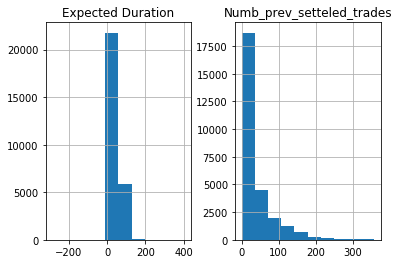

In [30]:
##### 2.1 The expected duration Histogram of data
df_modelling.hist()

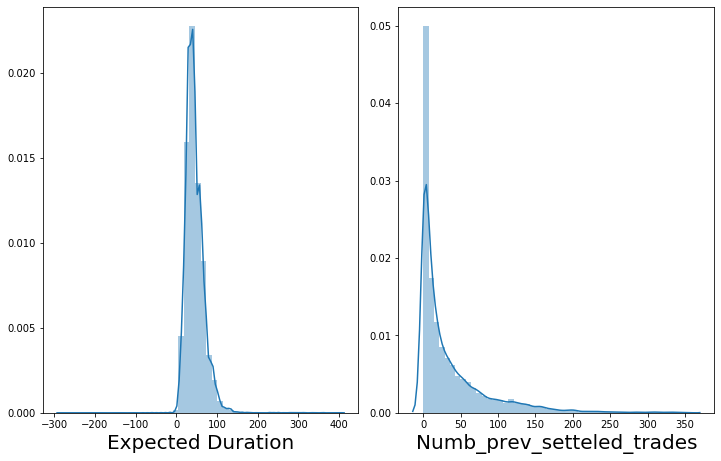

In [31]:
# let's see how data is distributed for every column
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in X:
    if plotnumber<=16 :
        ax = plt.subplot(4,4,plotnumber)
        sns.distplot(X[column])
        plt.xlabel(column,fontsize=20)
    plotnumber+=1
plt.tight_layout()

By looking into data distributions, Feature 'Number of settled traded are bit skewed to left' and random forest works well with such such type of data

#### 5.2 Random forest and recursive feature elimiation

There are various techniques to improve accuracy such as 
 - Hyper parameter tuning to find optimal parameters to train a model
 - Boosting technqiues
 - Adding more predictive features
 
I am using Recursive feature elimination with cross-validation to select the number of features.

In [32]:
df_std.head(3)

,Trade ID,Seller ID,Trade Type,Advance Date,Expected Payment Date,Settlement Date,In Arrears,In Arrears on Date,Crystallised Loss Date,Payment State,...,Discount %,Discount On (Advance or Face Value),Outstanding Principal,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Crystallised Loss,Expected Duration,Numb_prev_setteled_trades
0,60896,44830,Standard,2018-10-11,2019-01-07,NaT,No,NaT,NaT,Awaiting Repayment,...,1.0,Advance,2617.50,2637.9273,1978.4455,1978.4455,12.682503,NaN,88 days,5
1,61343,15942,Standard,2018-10-11,2018-11-26,NaT,No,NaT,NaT,Awaiting Repayment,...,0.7,Advance,5100.00,6000.0000,5100.0000,5100.0000,8.731066,NaN,46 days,53
2,61346,25937,Standard,2018-10-11,2018-12-14,NaT,No,NaT,NaT,Awaiting Repayment,...,1.2,Advance,2819.84,4338.2200,2819.8400,2819.8400,15.389462,NaN,64 days,4


In [33]:
df_std.columns

Index(['Trade ID', 'Seller ID', 'Trade Type', 'Advance Date',
       'Expected Payment Date', 'Settlement Date', 'In Arrears',
       'In Arrears on Date', 'Crystallised Loss Date', 'Payment State',
       'Price Grade', 'Currency', 'Face Value', 'Advance', 'Advance %',
       'Discount %', 'Discount On (Advance or Face Value)',
       'Outstanding Principal', 'Face Value (GBP)', 'Advance (GBP)',
       'Outstanding Principal (GBP)', 'Annualised Gross Yield %',
       'Crystallised Loss', 'Expected Duration', 'Numb_prev_setteled_trades'],
      dtype='object')

In [34]:
#spliting dependant and independent variables

# Dependent variables: Dates are ignored as we have already created two extra features to get respecitve information

X = df_std[['Payment State','Face Value (GBP)', 'Advance (GBP)','Outstanding Principal (GBP)','Annualised Gross Yield %','Expected Duration','Numb_prev_setteled_trades']]
X['Expected Duration']=pd.to_timedelta(X['Expected Duration']).dt.days

y = df_std['In Arrears']   #target column i.e In Arrears

In [35]:
X

,Payment State,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Expected Duration,Numb_prev_setteled_trades
0,Awaiting Repayment,2637.9273,1978.4455,1978.4455,12.682503,88,5
1,Awaiting Repayment,6000.0000,5100.0000,5100.0000,8.731066,46,53
2,Awaiting Repayment,4338.2200,2819.8400,2819.8400,15.389462,64,4
3,Awaiting Repayment,2904.0000,2323.2000,2323.2000,15.389462,71,34
4,Awaiting Repayment,44603.1100,40142.8000,40142.8000,10.033869,69,108
...,...,...,...,...,...,...,...
27761,Paid,17280.0000,14688.0000,0.0000,32.146043,24,0
27762,Paid,13500.0000,12150.0000,0.0000,14.164039,26,1
27763,Paid,3776.2700,3209.8295,0.0000,29.384044,28,0
27764,Paid,18318.0000,16486.2000,0.0000,14.164039,31,0


In [36]:
#Concatinating back to Original Data
X=pd.concat([X,pd.get_dummies(X['Payment State'],drop_first=True,prefix='Payment_State')],axis=1)
X.drop(['Payment State'],axis=1, inplace=True)
X

,Face Value (GBP),Advance (GBP),Outstanding Principal (GBP),Annualised Gross Yield %,Expected Duration,Numb_prev_setteled_trades,Payment_State_Overdue,Payment_State_Paid,Payment_State_Partially Paid,Payment_State_Repurchase Demanded,Payment_State_Repurchased
0,2637.9273,1978.4455,1978.4455,12.682503,88,5,0,0,0,0,0
1,6000.0000,5100.0000,5100.0000,8.731066,46,53,0,0,0,0,0
2,4338.2200,2819.8400,2819.8400,15.389462,64,4,0,0,0,0,0
3,2904.0000,2323.2000,2323.2000,15.389462,71,34,0,0,0,0,0
4,44603.1100,40142.8000,40142.8000,10.033869,69,108,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
27761,17280.0000,14688.0000,0.0000,32.146043,24,0,0,1,0,0,0
27762,13500.0000,12150.0000,0.0000,14.164039,26,1,0,1,0,0,0
27763,3776.2700,3209.8295,0.0000,29.384044,28,0,0,1,0,0,0
27764,18318.0000,16486.2000,0.0000,14.164039,31,0,0,1,0,0,0


In [37]:
# Train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
X_train.shape,y_train.shape,X_test.shape

((20824, 11), (20824,), (6942, 11))

In [38]:
#Checking data types
X_train.dtypes

Face Value (GBP)                     float64
Advance (GBP)                        float64
Outstanding Principal (GBP)          float64
Annualised Gross Yield %             float64
Expected Duration                      int64
Numb_prev_setteled_trades              int64
Payment_State_Overdue                  uint8
Payment_State_Paid                     uint8
Payment_State_Partially Paid           uint8
Payment_State_Repurchase Demanded      uint8
Payment_State_Repurchased              uint8
dtype: object

In [39]:
# Random forest modelling
from sklearn.ensemble import RandomForestClassifier
RandomForestClas = RandomForestClassifier(n_estimators = 10,random_state = 42)
#print(RandomForestClas())
RandomForestClas.fit(X_train,y_train)
y_pred=RandomForestClas.predict(X_test)

from sklearn.metrics import accuracy_score
print("Accuracy:",accuracy_score(y_test,y_pred))

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
print("F1 Score:",f1_score(y_test, y_pred, average="macro"))
print("Precision:",precision_score(y_test, y_pred, average="macro"))
print("Recall:",recall_score(y_test, y_pred, average="macro"))   

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9845865744742149
F1 Score: 0.7272463890515787
Precision: 0.8965370943699117
Recall: 0.6611630074565038
              precision    recall  f1-score   support

          No       0.99      1.00      0.99      6800
         Yes       0.81      0.32      0.46       142

    accuracy                           0.98      6942
   macro avg       0.90      0.66      0.73      6942
weighted avg       0.98      0.98      0.98      6942

[[6789   11]
 [  96   46]]


By looking into above results, random forest and adding more features increased the precision and recall of the model

The precision of the model Logistic Regression can be inferred as of all the points
where model predicted as yes, 81 percent are actually Yes. 

Similarly recall of model Logistic Regression can be inferred as of all the points that originally belong to class Yes, 32 percent were classified as class Yes

In [40]:
# Recursive feature elimination with cross-validation to select the number of features
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
RandomForestClas = RandomForestClassifier(n_estimators = 10,random_state = 42)

In [41]:
rfecv=RFECV(estimator=RandomForestClas,step=1,scoring='accuracy',min_features_to_select=1,cv=StratifiedKFold(2))

In [42]:
rfecv.fit(X,y)

RFECV(cv=StratifiedKFold(n_splits=2, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                       criterion='gini', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=10, n_jobs=None,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

Text(0.5, 1.0, 'RFECV')

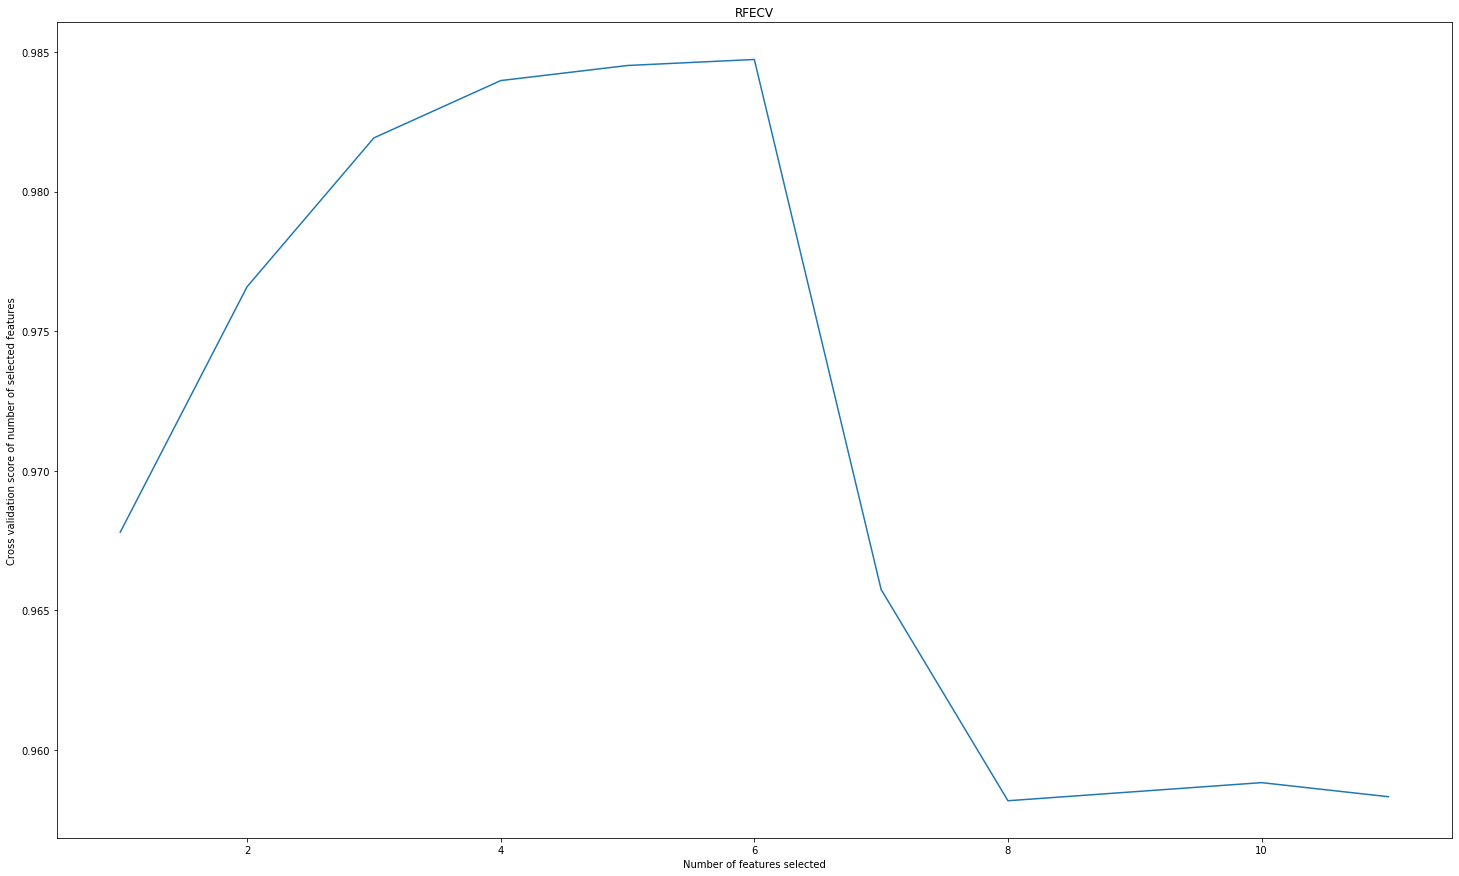

In [43]:
#PLot
plt.figure(figsize=(25,15), facecolor='white')
plt.plot(range(1,len(rfecv.grid_scores_)+1),rfecv.grid_scores_)
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score of number of selected features")
plt.title("RFECV")

In [44]:
#Extracting important featues

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols, query_cols, sorter = sidx)]

feature_index = []
features = []
column_index(X, X.columns.values)

for num, i in enumerate(rfecv.get_support(), start=0):
    if i == True:
        feature_index.append(str(num))

for num, i in enumerate(X.columns.values, start=0):
    if str(num) in feature_index:
        features.append(X.columns.values[num])

print("Features Selected: {}\n".format(len(feature_index)))
print("Features Indexes: \n{}\n".format(feature_index))
print("Feature Names: \n{}".format(features))

Features Selected: 6

Features Indexes: 
['0', '1', '3', '4', '5', '9']

Feature Names: 
['Face Value (GBP)', 'Advance (GBP)', 'Annualised Gross Yield %', 'Expected Duration', 'Numb_prev_setteled_trades', 'Payment_State_Repurchase Demanded']


According to RFECV, inaddition to featues we created, 'values' and 'payment state' can also be a good predictor variables